<a href="https://colab.research.google.com/github/Tommy-Las/WatfordFC/blob/main/ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and data

In [78]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
from collections import defaultdict
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.decomposition import PCA
import shap

In [79]:
file_path = 'data/cleaned_data_no_injured.xlsx'

# Load the CSV into a DataFrame
df = pd.read_excel(file_path)

# Display the DataFrame
df.head()

,DATE,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,PlayerID,...,Position_WINGER,Microcycle_M+1,Microcycle_M+2,Microcycle_M+3,Microcycle_M-1,Microcycle_M-2,Microcycle_M-3,Microcycle_M-4,Microcycle_M-5,Microcycle_MD
0,2021-08-12,0,2021-2022,SEASON,1701.0,0.0,0,14.0,7.0,10103,...,0,0,0,0,0,0,0,0,0,0
1,2021-08-13,0,2021-2022,SEASON,3593.0,54.0,1,45.0,22.0,10103,...,0,0,0,0,0,1,0,0,0,0
2,2021-08-15,0,2021-2022,SEASON,5802.0,92.0,0,94.0,53.0,10103,...,0,0,0,0,1,0,0,0,0,0
3,2021-08-17,0,2021-2022,SEASON,6056.0,275.0,44,74.0,60.0,10103,...,0,1,0,0,0,0,0,0,0,0
4,2021-08-18,0,2021-2022,SEASON,5985.0,288.0,154,73.0,79.0,10103,...,0,0,0,0,0,0,0,1,0,0


Class imbalance:

In [80]:
print("No Lesión: " + str(df[df["Injury"] == 0].shape[0]))
print("Lesión: " + str(df[df["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((df[df['Injury'] == 1].shape[0] / df.shape[0]) * 100):.2f}%")

No Lesión: 4381
Lesión: 36
Porcentaje de lesionados en el dataset: 0.82%


In [81]:
df.head()

,DATE,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,PlayerID,...,Position_WINGER,Microcycle_M+1,Microcycle_M+2,Microcycle_M+3,Microcycle_M-1,Microcycle_M-2,Microcycle_M-3,Microcycle_M-4,Microcycle_M-5,Microcycle_MD
0,2021-08-12,0,2021-2022,SEASON,1701.0,0.0,0,14.0,7.0,10103,...,0,0,0,0,0,0,0,0,0,0
1,2021-08-13,0,2021-2022,SEASON,3593.0,54.0,1,45.0,22.0,10103,...,0,0,0,0,0,1,0,0,0,0
2,2021-08-15,0,2021-2022,SEASON,5802.0,92.0,0,94.0,53.0,10103,...,0,0,0,0,1,0,0,0,0,0
3,2021-08-17,0,2021-2022,SEASON,6056.0,275.0,44,74.0,60.0,10103,...,0,1,0,0,0,0,0,0,0,0
4,2021-08-18,0,2021-2022,SEASON,5985.0,288.0,154,73.0,79.0,10103,...,0,0,0,0,0,0,0,1,0,0


# Correlation of variables

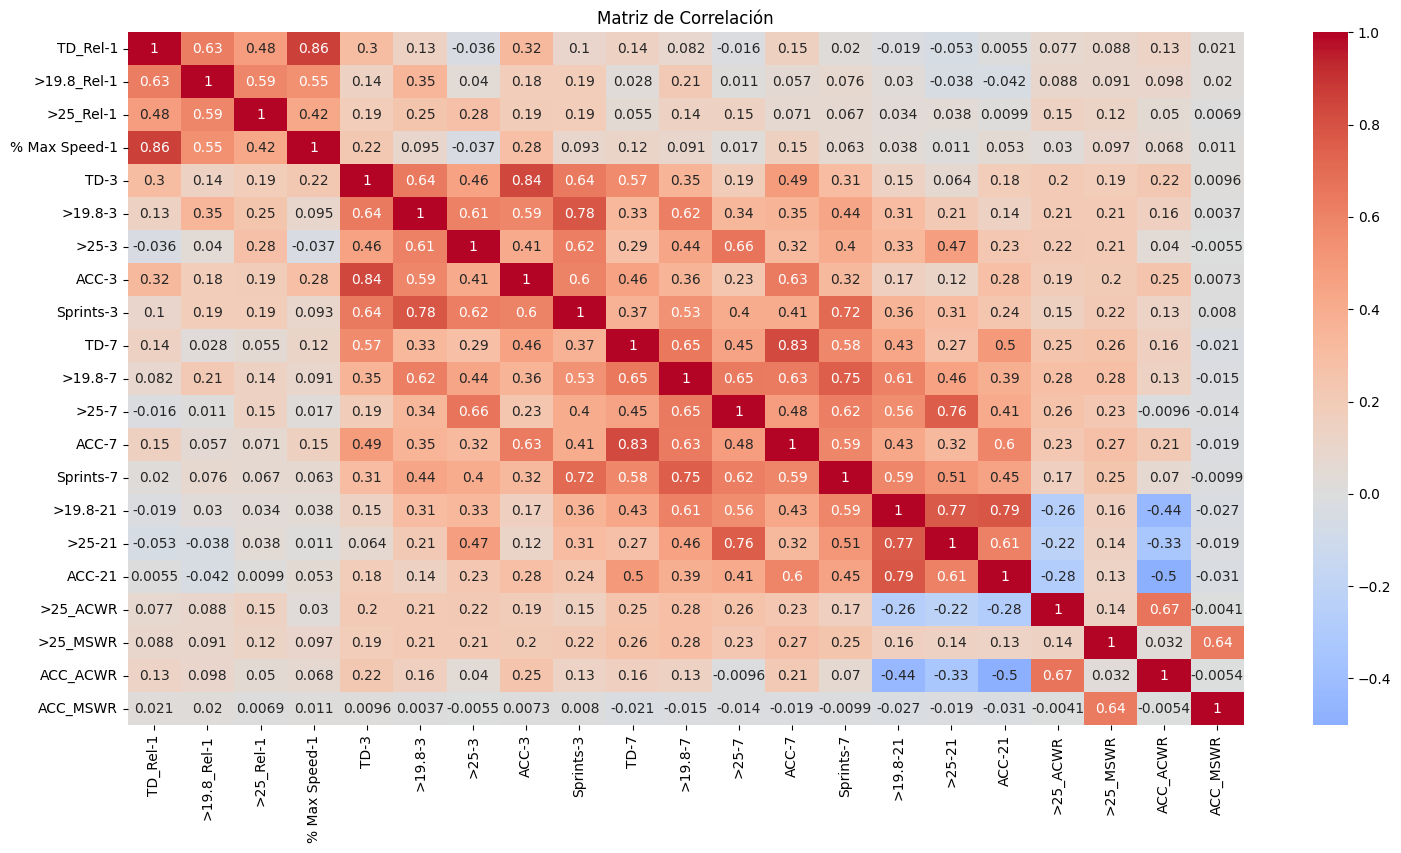

In [32]:
metrics = ['TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
       'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
       'Sprints-7', '>19.8-21', '>25-21', 'ACC-21', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR']

# Calcular la matriz de correlación
correlation_matrix = df[metrics].corr()

# Mostrar la matriz de correlación
plt.figure(figsize=(18, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()


In [33]:
df_with_constant = add_constant(df[metrics])

# Calcular el VIF para cada columna
vif_data = pd.DataFrame()
vif_data["Variable"] = df_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                   for i in range(df_with_constant.shape[1])]

# Mostrar el VIF
print(vif_data)

         Variable        VIF
0           const  37.345933
1        TD_Rel-1   5.109646
2     >19.8_Rel-1   2.770056
3       >25_Rel-1   1.909037
4   % Max Speed-1   3.997180
5            TD-3   9.880922
6         >19.8-3   7.585732
7           >25-3   4.094357
8           ACC-3   8.506115
9       Sprints-3  11.870469
10           TD-7   8.552423
11        >19.8-7   8.124830
12          >25-7   7.695737
13          ACC-7  11.795012
14      Sprints-7   9.889881
15       >19.8-21   7.369543
16         >25-21   6.673095
17         ACC-21   7.925699
18       >25_ACWR   3.024686
19       >25_MSWR   2.158119
20       ACC_ACWR   4.133702
21       ACC_MSWR   1.880967


# Filter data by date or season


In [169]:
# Season 2022-2023
# df_filtered = df[df['season']=='2022-2023']

# inj_2021 = df[(df['Injury'] == 1) & (df['season'] == '2021-2022')]
# df_filtered = pd.concat([df_filtered, inj_2021])

# Season 2021-2022
# df_filtered = df[df['season']=='2021-2022']

# Filter by no season
df_filtered = df.copy()

df_filtered = df_filtered[df_filtered['preseason-season'] != 'PRESEASON']

df_filtered.reset_index(drop=True, inplace=True)

df_sorted = df_filtered.sort_values(by='DATE', ascending=False).reset_index(drop=True)

df_sorted.head()

,DATE,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,PlayerID,...,Position_WINGER,Microcycle_M+1,Microcycle_M+2,Microcycle_M+3,Microcycle_M-1,Microcycle_M-2,Microcycle_M-3,Microcycle_M-4,Microcycle_M-5,Microcycle_MD
0,2023-05-10,0,2022-2023,SEASON,3115.0,173.0,0,33.0,51.0,87583,...,0,0,0,0,0,0,0,0,0,1
1,2023-05-10,0,2022-2023,SEASON,1763.0,25.0,0,16.0,6.0,23085,...,0,0,0,0,0,0,0,0,0,1
2,2023-05-09,0,2022-2023,SEASON,4444.0,98.0,0,51.0,36.0,89871,...,0,0,0,0,0,1,0,0,0,0
3,2023-05-08,0,2022-2023,SEASON,283.0,3.0,0,1.0,5.0,57090,...,0,0,0,0,1,0,0,0,0,0
4,2023-05-08,0,2022-2023,SEASON,3468.0,45.0,0,44.0,57.0,87583,...,0,0,0,0,1,0,0,0,0,0


# ML Models

## Separate data into X, y and player_ids

Initialize the features we want to train

In [84]:
df.columns

Index(['DATE', 'Injury', 'season', 'preseason-season', 'TD', '>19.8', '>25',
       'ACC', 'DEC', 'PlayerID', 'Max Speed', 'Sprints', 'Mins',
       'Max Speed Season', 'Avg Speed Season', '% Max Speed',
       'Speed Diff Max Avg', 'TD_Rel', '>19.8_Rel', '>25_Rel', 'ACC_Rel',
       'DEC_Rel', 'TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
       'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
       'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
       'DEC-3', 'Sprints-3', 'Mins-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
       'DEC-7', 'Sprints-7', 'Mins-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21', 'Mins-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
       '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
       'DEC_ACWR', 'DEC_MSWR', 'Position_CENTREBACK',
       'Position_CENTREMIDFIELDER', 'Position_FULLBACK', 'Position_STRIKER',
       'Position_WINGER', 'Microcycle_M+1', 'Microcycle_M+2', 'Micr

In [221]:
# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
#        'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'Mins-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'Mins-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21', 'Sprints-21', 'Mins-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR']

metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
       'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
       'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
       'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
       'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
       '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
       'DEC_ACWR', 'DEC_MSWR','Microcycle_M+1', 'Microcycle_M+2', 'Microcycle_M+3',
       'Microcycle_M-1', 'Microcycle_M-2', 'Microcycle_M-3', 'Microcycle_M-4',
       'Microcycle_M-5', 'Microcycle_MD']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
#        'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
#        'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'Sprints-1',
#        'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR']

# metrics_train = ['Injury', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'Sprints-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'Sprints-7', '>19.8-21', '>25-21', 'ACC-21', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
#        'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR']

print(len(metrics_train))

51


## Split data

We want to also store the 'DATE' & 'PlayerID' columns for later comparison

In [305]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

### Split by selecting 10 first injuries and its past 30 days

#### Days

In [273]:
# Parameter: Number of injuries for the test set
num_test_injuries = 14  # Number of injuries to include in the test set

# Step 1: Identify rows where `Injury` occurred (Injury == 1)
injury_rows = df_sorted[df_sorted['Injury'] == 1]

# Step 2: Select the first `num_test_injuries` injuries for the test set
test_injury_indices = injury_rows.index[:num_test_injuries]

# Step 3: Collect past 30 days of data for each test injury
test_indices = set()

days_before_test = 30
days_before_train = 80

for idx in test_injury_indices:
    injury_date = df_sorted.loc[idx, 'DATE']
    player_id = df_sorted.loc[idx, 'PlayerID']
    # Collect all rows for this player in the past 30 days
    past_30_days_indices = df_sorted[
        (df_sorted['PlayerID'] == player_id) &
        (df_sorted['DATE'] <= injury_date) &
        (df_sorted['DATE'] > injury_date - pd.Timedelta(days=days_before_test))
    ].index
    test_indices.update(past_30_days_indices)

# Step 4: Select the remaining injuries for the training set
remaining_injury_indices = injury_rows.index.difference(test_injury_indices)

train_indices = set()

for idx in remaining_injury_indices:
    injury_date = df_sorted.loc[idx, 'DATE']
    player_id = df_sorted.loc[idx, 'PlayerID']
    # Collect all rows for this player in the past 30 days, excluding test indices
    past_30_days_indices = df_sorted[
        (df_sorted['PlayerID'] == player_id) &
        (df_sorted['DATE'] <= injury_date) &
        (df_sorted['DATE'] > injury_date - pd.Timedelta(days=days_before_train))
    ].index
    train_indices.update(set(past_30_days_indices).difference(test_indices))

# Convert to lists
test_indices = list(test_indices)
train_indices = list(train_indices)

# Step 5: Create training and test sets
X_test = X.loc[test_indices]
y_test = y.loc[test_indices]

X_train = X.loc[train_indices]
y_train = y.loc[train_indices]

# Optional: Extra columns for test and training sets
extra_cols_test = extra_cols.loc[test_indices]
extra_cols_train = extra_cols.loc[train_indices]

# Sanity check for dataset sizes
print(f"Number of rows in test set: {len(X_test)}")
print(f"Number of rows in training set: {len(X_train)}")


Number of rows in test set: 269
Number of rows in training set: 693


#### Rows

In [306]:
import random

# Ensure the data is sorted by PlayerID and DATE
df_sorted = df_sorted.sort_values(by=['PlayerID', 'DATE']).reset_index(drop=True)

# Parameter: Number of injuries for the test set
num_test_injuries = 10  # Number of injuries to include in the test set

# Identify rows where `Injury` occurred (Injury == 1)
injury_rows = df_sorted[df_sorted['Injury'] == 1]

# Step 1: Randomly select indices for testing and training injuries
random.seed(42)  # Set seed for reproducibility
all_injury_indices = list(injury_rows.index)
test_injury_indices = random.sample(all_injury_indices, num_test_injuries)
train_injury_indices = list(set(all_injury_indices).difference(test_injury_indices))

# Step 2: Collect rows for testing set
test_indices = set(test_injury_indices)  # Start with rows where Injury == 1
rows_before_test = 7

for idx in test_injury_indices:
    player_id = df_sorted.loc[idx, 'PlayerID']
    player_data = df_sorted[df_sorted['PlayerID'] == player_id]
    
    # Find the position of the current injury in the player's data
    injury_pos = player_data.index.get_loc(idx)
    
    # Collect the previous rows (or as many as available)
    past_rows = player_data.iloc[max(0, injury_pos - rows_before_test):injury_pos].index.tolist()
    test_indices.update(past_rows)

# Step 3: Collect rows for training set
train_indices = set(train_injury_indices)  # Start with rows where Injury == 1
rows_before_train = 20

for idx in train_injury_indices:
    player_id = df_sorted.loc[idx, 'PlayerID']
    player_data = df_sorted[df_sorted['PlayerID'] == player_id]
    
    # Find the position of the current injury in the player's data
    injury_pos = player_data.index.get_loc(idx)
    
    # Collect the previous rows (or as many as available)
    past_rows = player_data.iloc[max(0, injury_pos - rows_before_train):injury_pos].index.tolist()
    train_indices.update(past_rows)

# Step 4: Remove duplicates from indices and ensure no overlap
test_indices = list(test_indices)
train_indices = list(set(train_indices).difference(test_indices))

# Step 5: Create the datasets
training = df_sorted.loc[train_indices]
testing = df_sorted.loc[test_indices]

X_train = training[metrics_train].reset_index(drop=True)
X_test = testing[metrics_train].reset_index(drop=True)
y_train = training['Injury'].reset_index(drop=True)
y_test = testing['Injury'].reset_index(drop=True)

# Step 6: Validate datasets
print(f"Number of rows in X_train: {len(X_train)}")
print(f"Number of rows in X_test: {len(X_test)}")
print(f"Number of injuries in y_train: {y_train.sum()}")
print(f"Number of injuries in y_test: {y_test.sum()}")

Number of rows in X_train: 507
Number of rows in X_test: 80
Number of injuries in y_train: 25
Number of injuries in y_test: 10


In [307]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")
print("No Lesión: " + str(X_test[X_test["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_test[X_test["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_test[X_test['Injury'] == 1].shape[0] / X_test.shape[0]) * 100):.2f}%")
X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

No Lesión: 482
Lesión: 25
Porcentaje de lesionados en el dataset: 4.93%
No Lesión: 70
Lesión: 10
Porcentaje de lesionados en el dataset: 12.50%


### Split by first %X for validating and rest for training

In [162]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

# Determine the split index for X% testing
percentage_validation = 0.3
split_index = int(percentage_validation * len(df_sorted))

# Split the data
X_test = X.iloc[:split_index].reset_index(drop=True)
X_train = X.iloc[split_index:].reset_index(drop=True)
y_test = y.iloc[:split_index].reset_index(drop=True)
y_train = y.iloc[split_index:].reset_index(drop=True)
extra_cols_test = extra_cols.iloc[:split_index].reset_index(drop=True)
extra_cols_train = extra_cols.iloc[split_index:].reset_index(drop=True)

Select less amount of data

In [163]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")

No Lesión: 2883
Lesión: 22
Porcentaje de lesionados en el dataset: 0.76%


In [118]:
# Sort X_train by index
X_train = X_train.sort_index()  # Sort by date or relevant index if not already sorted.
y_train = y_train.sort_index()  # Ensure y_train matches X_train in order.

# Filter rows where 'Injury' == 1
injury_rows = X_train[X_train['Injury'] == 1]

# Get 30 days before each injury
# Assuming a datetime index, otherwise adjust for your date representation
indices_to_include = set(injury_rows.index)

for idx in injury_rows.index:
    # Include 30 rows before the 'Injury == 1', ensure not out of bounds
    start_idx = max(0, idx - 30)
    indices_to_include.update(range(start_idx, idx + 1))

# Create a dataframe with required rows (Injury == 1 and 30 days before)
selected_rows = X_train.loc[list(indices_to_include)]
selected_y = y_train.loc[selected_rows.index]  # Match y_train with selected rows

# Get the remaining rows not in `selected_rows`
remaining_rows = X_train.drop(selected_rows.index)
remaining_y = y_train.drop(selected_y.index)

# Proportion for sampling (e.g., 50%)
sample_proportion = 0.5
n_to_sample = int(len(X_train) * sample_proportion - len(selected_rows))

# Randomly sample from the remaining rows
sampled_rows = remaining_rows.sample(n=n_to_sample, random_state=42)
sampled_y = remaining_y.loc[sampled_rows.index]

# Combine the selected rows and sampled rows
X_train = pd.concat([selected_rows, sampled_rows]).sort_index().reset_index(drop=True)
y_train = pd.concat([selected_y, sampled_y]).sort_index().reset_index(drop=True)


In [119]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Injury      809 non-null    int64  
 1   TD-1        809 non-null    float64
 2   >19.8-1     809 non-null    int64  
 3   >25-1       809 non-null    int64  
 4   ACC-1       809 non-null    float64
 5   DEC-1       809 non-null    float64
 6   Sprints-1   809 non-null    int64  
 7   TD-3        809 non-null    float64
 8   >19.8-3     809 non-null    float64
 9   >25-3       809 non-null    int64  
 10  ACC-3       809 non-null    float64
 11  DEC-3       809 non-null    float64
 12  Sprints-3   809 non-null    int64  
 13  TD-7        809 non-null    float64
 14  >19.8-7     809 non-null    float64
 15  >25-7       809 non-null    int64  
 16  ACC-7       809 non-null    float64
 17  DEC-7       809 non-null    float64
 18  Sprints-7   809 non-null    int64  
 19  TD-21       809 non-null    f

In [120]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")

No Lesión: 789
Lesión: 20
Porcentaje de lesionados en el dataset: 2.47%


In [164]:
X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

### Split random 

In [146]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

# Split the data into training and test sets
# X_train, X_test, y_train, y_test, extra_cols_train, extra_cols_test = train_test_split(X, y, extra_cols, test_size=0.3, random_state=42, stratify=y)
X_train, X_test, y_train, y_test, extra_cols_train, extra_cols_test = train_test_split(X, y, extra_cols, test_size=0.3, random_state=42, stratify=y)

X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
extra_cols_train.reset_index(drop=True, inplace=True)
extra_cols_test.reset_index(drop=True, inplace=True)


## SMOTE or SMOTEEN oversampling technique

In [309]:
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train , y_train = smote.fit_resample(X_train, y_train)

# Apply SMOTEEN to training data
# smote_enn = SMOTEENN(random_state=42)
# X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts())

Class distribution after SMOTE:
Injury
0    482
1    482
Name: count, dtype: int64
Injury
0    482
1    482
Name: count, dtype: int64


## Logistic Regression

Initialize logistic regression and normalize the data

In [317]:
no_scaled = ['Microcycle_M+1', 'Microcycle_M+2', 'Microcycle_M+3',
       'Microcycle_M-1', 'Microcycle_M-2', 'Microcycle_M-3', 'Microcycle_M-4',
       'Microcycle_M-5', 'Microcycle_MD']

# Create the model
logistic_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

# Initialize the scaler
scaler = StandardScaler()

# Columns to scale: exclude those in no_scaled
scaled_columns = [col for col in X_train.columns if col not in no_scaled]

# Scale only the selected columns
X_train_scaled_part = scaler.fit_transform(X_train[scaled_columns])
X_test_scaled_part = scaler.transform(X_test[scaled_columns])

# Convert scaled parts back to DataFrame
X_train_scaled_part = pd.DataFrame(X_train_scaled_part, columns=scaled_columns, index=X_train.index)
X_test_scaled_part = pd.DataFrame(X_test_scaled_part, columns=scaled_columns, index=X_test.index)

# Add the unscaled columns back
X_train_scaled = pd.concat([X_train_scaled_part, X_train[no_scaled]], axis=1)
X_test_scaled = pd.concat([X_test_scaled_part, X_test[no_scaled]], axis=1)

# Ensure column order matches the original
X_train_scaled = X_train_scaled[X_train.columns]
X_test_scaled = X_test_scaled[X_test.columns]

### Logistic Regression Active learning 

to dynamically select data

In [214]:
# Initialize datasets
X_all = X_train_scaled  # Scaled features
y_all = y_train.values  # Labels

# Start with a small labeled dataset from the bottom of the sorted DataFrame
initial_samples = 50  # Number of initial samples
X_train_active = X_all[-initial_samples:]  # Select the last `initial_samples` rows
y_train_active = y_all[-initial_samples:]  # Corresponding labels

# Remaining unlabeled pool (everything except the selected rows)
X_pool = X_all[:-initial_samples]
y_pool = y_all[:-initial_samples]

print(f"Initial training set size: {len(X_train_active)}")
print(f"Remaining pool size: {len(X_pool)}")

Initial training set size: 50
Remaining pool size: 1634


In [215]:
# Parameters for active learning
n_iterations = 250  # Number of active learning iterations
samples_per_iteration = 5  # Samples to add in each iteration

# To store metrics for visualization
train_recall_label1_scores = []
train_sizes = []

for i in range(n_iterations):
    # Train the model on the current labeled dataset
    logistic_model.fit(X_train_active, y_train_active)
    
    # Predict probabilities for the unlabeled pool
    probs = logistic_model.predict_proba(X_pool)[:, 1]
    
    # Find the most uncertain samples (probabilities closest to 0.5)
    uncertainty = np.abs(probs - 0.5)  # Uncertainty measure
    uncertain_indices = np.argsort(uncertainty)[:samples_per_iteration]
    
    # Add the most uncertain samples to the training set
    X_train_active = np.vstack((X_train_active, X_pool[uncertain_indices]))
    y_train_active = np.hstack((y_train_active, y_pool[uncertain_indices]))
    
    # Remove these samples from the pool
    X_pool = np.delete(X_pool, uncertain_indices, axis=0)
    y_pool = np.delete(y_pool, uncertain_indices, axis=0)
    
    # Evaluate recall for label 1
    y_train_pred = logistic_model.predict(X_train_active)
    recall_label1 = recall_score(y_train_active, y_train_pred, pos_label=1)  # Focus on label 1
    train_recall_label1_scores.append(recall_label1)
    train_sizes.append(len(y_train_active))
    
    print(f"Iteration {i + 1}/{n_iterations}:")
    print(f"Training Recall for Label 1: {recall_label1:.4f}")
    print(f"Training Size: {len(y_train_active)}")
    
    
# Plot recall improvement for label 1
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_recall_label1_scores, marker='o', label="Recall for Label 1")
plt.xlabel("Training Set Size")
plt.ylabel("Recall for Label 1")
plt.title("Recall Improvement for Label 1 During Active Learning")
plt.legend()
plt.grid()
plt.show()

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

In [65]:
# Evaluate on test data
y_test_pred = logistic_model.predict(X_test_scaled)
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))



Test Set Evaluation:
Accuracy: 0.8371757925072046
Confusion Matrix:
 [[579 108]
 [  5   2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91       687
           1       0.02      0.29      0.03         7

    accuracy                           0.84       694
   macro avg       0.50      0.56      0.47       694
weighted avg       0.98      0.84      0.90       694



### Regular logistic regression

In [318]:
# Train the model
logistic_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = logistic_model.predict(X_train_scaled)
y_test_pred = logistic_model.predict(X_test_scaled)

# Probabilities
y_test_probs = logistic_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class

# Training evaluation
print("Training Set Evaluation:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# Test evaluation
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Training Set Evaluation:
Accuracy: 0.9336099585062241
Confusion Matrix:
 [[424  58]
 [  6 476]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93       482
           1       0.89      0.99      0.94       482

    accuracy                           0.93       964
   macro avg       0.94      0.93      0.93       964
weighted avg       0.94      0.93      0.93       964


Test Set Evaluation:
Accuracy: 0.825
Confusion Matrix:
 [[60 10]
 [ 4  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90        70
           1       0.38      0.60      0.46        10

    accuracy                           0.82        80
   macro avg       0.66      0.73      0.68        80
weighted avg       0.87      0.82      0.84        80



Find the best threshold

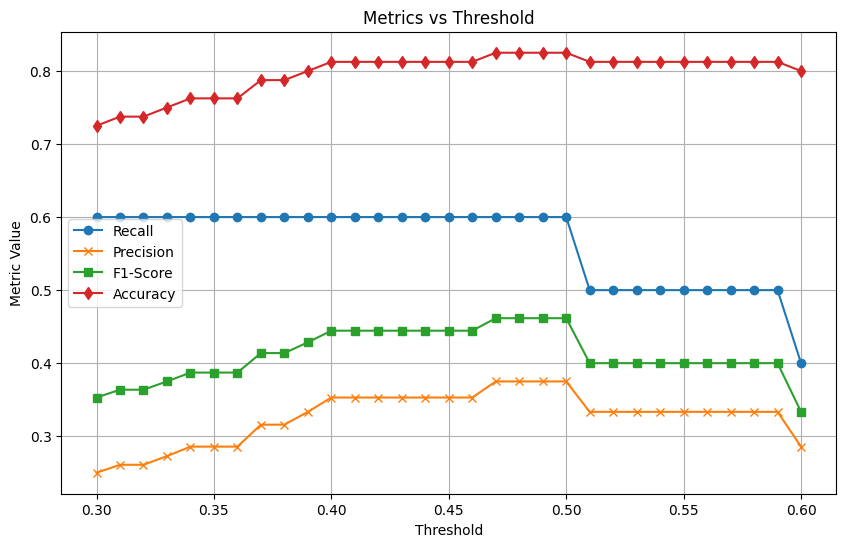

In [321]:
# Thresholds to evaluate (from 0.3 to 0.6 in steps of 0.01)
thresholds = np.arange(0.3, 0.61, 0.01)  # Thresholds from 0 to 1 in steps of 0.01

# Store results
results = []

for threshold in thresholds:
    # Generate predictions for the current threshold
    y_pred = (y_test_probs >= threshold).astype(int)
    
    # Calculate metrics
    recall = recall_score(y_test, y_pred, pos_label=1)  # Recall for label 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append metrics and threshold to results
    results.append({
        'Threshold': threshold,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'Accuracy': accuracy
    })
    
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='x')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='s')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='d')
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs Threshold")
plt.legend()
plt.grid()
plt.show()

ROC Curve with manually selecting the threshold

Number of unique thresholds: 18

Manually Selected Threshold: 0.40

Evaluation with Manually Selected Threshold:
Accuracy: 0.8125
Confusion Matrix:
 [[59 11]
 [ 4  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.84      0.89        70
           1       0.35      0.60      0.44        10

    accuracy                           0.81        80
   macro avg       0.64      0.72      0.67        80
weighted avg       0.86      0.81      0.83        80



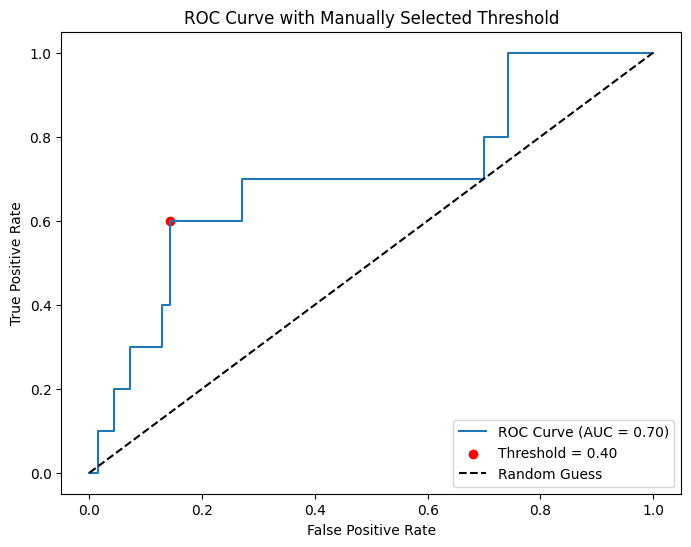

In [322]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)

# Print the number of unique thresholds
print(f"Number of unique thresholds: {len(thresholds)}")

# Manually select the threshold
manual_threshold = 0.4 # Manually chosen threshold
print(f"\nManually Selected Threshold: {manual_threshold:.2f}")

# Apply the manually selected threshold
y_test_pred_manual = (y_test_probs >= manual_threshold).astype(int)

# Evaluate the model with the manually selected threshold
print("\nEvaluation with Manually Selected Threshold:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_manual))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_manual))
print("Classification Report:\n", classification_report(y_test, y_test_pred_manual))

# Find the index of the manually selected threshold in the ROC data
# Using `thresholds` from the ROC calculation
manual_idx = np.argmin(np.abs(thresholds - manual_threshold))

# Plot the ROC curve and mark the manually selected threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.scatter(fpr[manual_idx], tpr[manual_idx], color="red", label=f"Threshold = {manual_threshold:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Manually Selected Threshold")
plt.legend(loc="lower right")
plt.show()

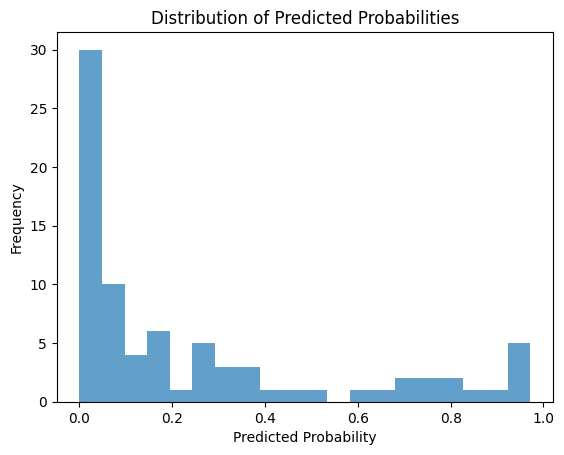

In [324]:
plt.hist(y_test_probs, bins=20, alpha=0.7)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

Store the coeficients

In [325]:
# Reset index for consistency
extra_cols_test.reset_index(inplace=True, drop=True)

# Get coefficients and intercept
coefficients = logistic_model.coef_[0]  # Coefficients
intercept = logistic_model.intercept_[0]  # Intercept
features = X_test.columns  # Feature names

# Create the player-score DataFrame
df_a = pd.DataFrame({
    'Player': extra_cols_test['PlayerID'],
    'Date': extra_cols_test['DATE'],
    'Score': y_test_probs,
    'Actual': y_test.reset_index(drop=True)
})

# Add feature values and calculate z (linear combination)
for i, feature in enumerate(features):
    df_a[feature] = X_test_scaled[:, i]  # Add scaled feature values
    df_a[f'Coeff_{feature}'] = coefficients[i]  # Add coefficient for each feature

# Calculate the linear combination (z) for each row
df_a['Linear_Combination'] = (
    np.dot(X_test_scaled, coefficients) + intercept
)

# Display the resulting DataFrame
print("\nPlayer, Date, Feature Contributions, Linear Combination, and Score DataFrame:")
df_a.head()


ValueError: array length 80 does not match index length 696

Find the features that affect the injuries the most

In [326]:
# Assuming your features are in a DataFrame
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,  # Replace with your feature names
    "Importance": logistic_model.coef_[0]  # Coefficients from logistic regression
})

# Sort by importance
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Display the feature importance
print(feature_importance)

           Feature  Importance
27          >25-21    1.741728
7         TD_Rel-1    1.629744
24       Sprints-7    1.546621
35        >25_ACWR    1.434165
13            TD-3    1.304493
12   % Max Speed-1    1.224443
40        DEC_MSWR    1.023218
4            DEC-1    0.991589
31         TD_ACWR    0.679321
23           DEC-7    0.659300
16           ACC-3    0.513648
22           ACC-7    0.480000
38        ACC_MSWR    0.470384
5        Sprints-1    0.397404
36        >25_MSWR    0.204799
20         >19.8-7    0.196390
15           >25-3    0.171168
0             TD-1    0.138524
39        DEC_ACWR    0.108082
2            >25-1    0.017412
14         >19.8-3   -0.019533
28          ACC-21   -0.157563
29          DEC-21   -0.188142
1          >19.8-1   -0.365194
8      >19.8_Rel-1   -0.432846
34      >19.8_MSWR   -0.445345
11       DEC_Rel-1   -0.450434
33      >19.8_ACWR   -0.456532
6           Mins-1   -0.576244
19            TD-7   -0.604957
26        >19.8-21   -0.610938
17      

Select X quantity of the top features and retrain the model

In [234]:
# Extract top features by absolute importance
num_top_features =  20 # Adjust this to include the number of features you want
top_features = feature_importance.iloc[:num_top_features]["Feature"].values

print(f"Selected Top {num_top_features} Features: {top_features}")

Selected Top 20 Features: ['>25-21' 'Sprints-7' 'TD_Rel-1' '% Max Speed-1' 'DEC_MSWR' 'DEC-1' 'TD-3'
 '>19.8-7' '>25_ACWR' 'ACC-3' 'DEC_ACWR' 'TD_ACWR' 'ACC-7' '>25-3'
 '>25_MSWR' 'TD-21' 'DEC-7' 'ACC_MSWR' 'DEC_Rel-1' '>19.8-3']


Updated Model Evaluation:
Accuracy: 0.5272727272727272
Confusion Matrix:
 [[26 24]
 [ 2  3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.52      0.67        50
           1       0.11      0.60      0.19         5

    accuracy                           0.53        55
   macro avg       0.52      0.56      0.43        55
weighted avg       0.85      0.53      0.62        55



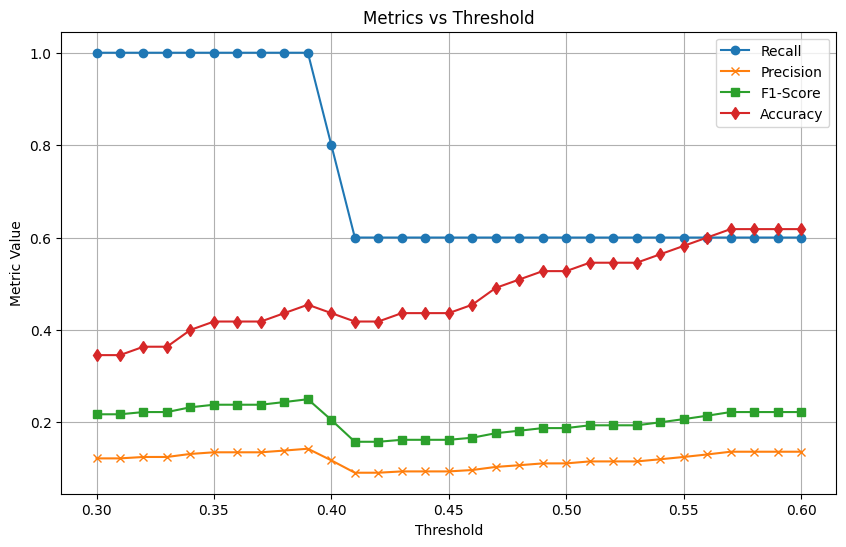

In [235]:
# Filter the training and testing data for top features
X_train_top = X_train_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]
X_test_top = X_test_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]

# Train logistic regression with top features
logistic_model_top = LogisticRegression(random_state=42, max_iter=1000)
logistic_model_top.fit(X_train_top, y_train)

# Predictions
y_test_pred_top = logistic_model_top.predict(X_test_top)
y_test_probs_top = logistic_model_top.predict_proba(X_test_top)[:, 1]

# Evaluate performance
print("Updated Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_top))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_top))
print("Classification Report:\n", classification_report(y_test, y_test_pred_top))

# Thresholds to evaluate (from 0.3 to 0.6 in steps of 0.01)
thresholds = np.arange(0.3, 0.61, 0.01)  # Thresholds from 0 to 1 in steps of 0.01

# Store results
results = []

for threshold in thresholds:
    # Generate predictions for the current threshold
    y_pred = (y_test_probs_top >= threshold).astype(int)
    
    # Calculate metrics
    recall = recall_score(y_test, y_pred, pos_label=1)  # Recall for label 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append metrics and threshold to results
    results.append({
        'Threshold': threshold,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'Accuracy': accuracy
    })
    
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='x')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='s')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='d')
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs Threshold")
plt.legend()
plt.grid()
plt.show()

Number of unique thresholds: 11

Manually Selected Threshold: 0.40

Evaluation with Manually Selected Threshold:
Accuracy: 0.43636363636363634
Confusion Matrix:
 [[20 30]
 [ 1  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.40      0.56        50
           1       0.12      0.80      0.21         5

    accuracy                           0.44        55
   macro avg       0.54      0.60      0.38        55
weighted avg       0.88      0.44      0.53        55



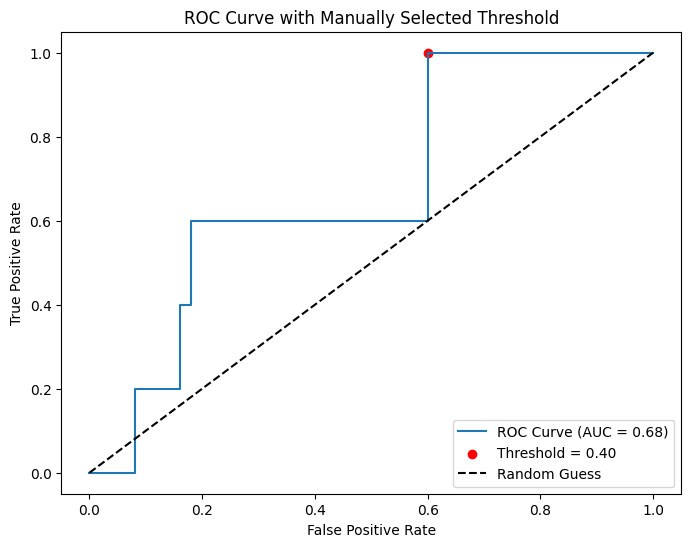

In [236]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs_top)
roc_auc = auc(fpr, tpr)

# Print the number of unique thresholds
print(f"Number of unique thresholds: {len(thresholds)}")

# Manually select the threshold
manual_threshold = 0.4  # Manually chosen threshold
print(f"\nManually Selected Threshold: {manual_threshold:.2f}")

# Apply the manually selected threshold
y_test_pred_manual = (y_test_probs_top >= manual_threshold).astype(int)

# Evaluate the model with the manually selected threshold
print("\nEvaluation with Manually Selected Threshold:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_manual))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_manual))
print("Classification Report:\n", classification_report(y_test, y_test_pred_manual))

# Find the index of the manually selected threshold in the ROC data
# Using `thresholds` from the ROC calculation
manual_idx = np.argmin(np.abs(thresholds - manual_threshold))

# Plot the ROC curve and mark the manually selected threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.scatter(fpr[manual_idx], tpr[manual_idx], color="red", label=f"Threshold = {manual_threshold:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Manually Selected Threshold")
plt.legend(loc="lower right")
plt.show()

## RNN

In [105]:
import pandas as pd
import numpy as np

def create_rnn_datasets(df_sorted, RNN_metrics, sequence_length=30, train_ratio=0.7, val_ratio=0.15):
    """
    Create training, validation, and testing datasets for RNNs.
    
    Args:
        df_sorted (pd.DataFrame): The sorted DataFrame containing the data.
        RNN_metrics (list): List of metric columns to be used as features for training.
        sequence_length (int): The length of each sequence (e.g., 30 days).
        train_ratio (float): The ratio of data to use for training.
        val_ratio (float): The ratio of data to use for validation.
        
    Returns:
        tuple: (X_train, y_train), (X_val, y_val), (X_test, y_test)
        - Each dataset is in the shape (num_sequences, sequence_length, num_features).
    """
    sequences = []
    labels = []
    
    # Group by PlayerID to create sequences for each player
    grouped = df_sorted.groupby('PlayerID')
    
    for player_id, group in grouped:
        # Ensure the group is sorted by date (if not already)
        group = group.sort_values(by='DATE')
        
        # Iterate through the rows to create sequences
        for i in range(len(group) - sequence_length):
            # Get the current sequence (last 30 days)
            sequence = group.iloc[i:i+sequence_length][RNN_metrics].values
            # Get the injury label at the end of the sequence
            label = group.iloc[i+sequence_length]['Injury']
            
            # Append the sequence and label
            sequences.append(sequence)
            labels.append(label)
    
    # Convert to numpy arrays
    sequences = np.array(sequences)  # Shape: (num_sequences, sequence_length, num_features)
    labels = np.array(labels)        # Shape: (num_sequences,)
    
    # Split into train, validation, and test datasets
    num_sequences = len(sequences)
    train_end = int(num_sequences * train_ratio)
    val_end = train_end + int(num_sequences * val_ratio)
    
    X_train, y_train = sequences[:train_end], labels[:train_end]
    X_val, y_val = sequences[train_end:val_end], labels[train_end:val_end]
    X_test, y_test = sequences[val_end:], labels[val_end:]
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


In [106]:
# RNN_metrics =  ['TD-3' 'DEC_MSWR' 'Sprints-7' '% Max Speed-1' 'DEC-21' 'ACC-3' 'DEC-1'
#  'TD_Rel-1' 'TD_ACWR' '>19.8-21' 'DEC-7' 'Mins-1' '>25-21' '>25_ACWR'
#  'ACC-7' '>25_MSWR' 'DEC_ACWR' 'ACC_MSWR' '>25-3' '>19.8_Rel-1']
RNN_metrics = metrics_train

In [107]:
RNN_metrics = metrics_train
(X_train, y_train), (X_val, y_val), (X_test, y_test) = create_rnn_datasets(df_sorted, RNN_metrics)

print("Training Data Shape:", X_train.shape, y_train.shape)
print("Validation Data Shape:", X_val.shape, y_val.shape)
print("Testing Data Shape:", X_test.shape, y_test.shape)

Training Data Shape: (2421, 30, 45) (2421,)
Validation Data Shape: (518, 30, 45) (518,)
Testing Data Shape: (520, 30, 45) (520,)


In [108]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming X_train, X_val, X_test are 3D: (n_sequences, sequence_length, n_features)
# Flatten the data for scaling
n_sequences, sequence_length, n_features = X_train.shape

# Reshape data to 2D for scaling
X_train_flat = X_train.reshape(-1, n_features)  # Shape: (n_sequences * sequence_length, n_features)
X_val_flat = X_val.reshape(-1, n_features)      # Shape: (n_sequences * sequence_length, n_features)
X_test_flat = X_test.reshape(-1, n_features)    # Shape: (n_sequences * sequence_length, n_features)

# Initialize and fit the scaler on training data only
scaler = StandardScaler()
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_val_scaled_flat = scaler.transform(X_val_flat)
X_test_scaled_flat = scaler.transform(X_test_flat)

# Reshape the scaled data back to 3D for RNN input
X_train_scaled = X_train_scaled_flat.reshape(n_sequences, sequence_length, n_features)
X_val_scaled = X_val_scaled_flat.reshape(X_val.shape[0], sequence_length, n_features)
X_test_scaled = X_test_scaled_flat.reshape(X_test.shape[0], sequence_length, n_features)

# Outputs
print(f"Train Shape: {X_train_scaled.shape}, Validation Shape: {X_val_scaled.shape}, Test Shape: {X_test_scaled.shape}")
print(f"y_train Distribution: {np.bincount(y_train)}, y_val Distribution: {np.bincount(y_val)}, y_test Distribution: {np.bincount(y_test)}")


Train Shape: (2421, 30, 45), Validation Shape: (518, 30, 45), Test Shape: (520, 30, 45)
y_train Distribution: [2401   20], y_val Distribution: [514   4], y_test Distribution: [516   4]


In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def create_rnn(input_shape):
    model = Sequential()

    # LSTM layer
    model.add(LSTM(units=64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3))

    # Second LSTM layer
    model.add(LSTM(units=32, return_sequences=False))
    model.add(Dropout(0.3))

    # Fully connected output layer
    model.add(Dense(units=1, activation='sigmoid'))  # Binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Input shape for RNN
input_shape = (timesteps, n_features)

# Create the model
model = create_rnn(input_shape)

/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [110]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to a dictionary for Keras
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Train the model
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    verbose=1, 
    callbacks=[early_stopping, lr_scheduler],
    class_weight = class_weights
)


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8723 - loss: 0.8114 - val_accuracy: 0.2239 - val_loss: 0.7503 - learning_rate: 0.0010
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6924 - loss: 0.7057 - val_accuracy: 0.2162 - val_loss: 0.7566 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6415 - loss: 0.6711 - val_accuracy: 0.7278 - val_loss: 0.6105 - learning_rate: 0.0010
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7391 - loss: 0.6700 - val_accuracy: 0.4788 - val_loss: 0.6479 - learning_rate: 0.0010
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6498 - loss: 0.4953 - val_accuracy: 0.8707 - val_loss: 0.5175 - learning_rate: 0.0010
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6412 - loss: 0.4887 - val_accuracy: 0.9923 - val_loss: 0.4173 - learning_rate: 0.0010
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8402 - loss: 0.3715 - val_accuracy: 

In [111]:
loss, accuracy = model.evaluate(X_train_scaled, y_test, verbose=0)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Get predictions
test_predictions = model.predict(X_train_scaled)
ipi_test_scores = test_predictions[:, 0]  # Injury Prevention Index

# Generate predictions for the test set
y_pred_probs = model.predict(X_train_scaled)  # Probabilities from the model
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 2421
'y' sizes: 520


## ANN

In [237]:
# metrics_ANN =  ['TD-3' 'DEC_MSWR' 'Sprints-7' '% Max Speed-1' 'DEC-21' 'ACC-3' 'DEC-1'
#  'TD_Rel-1' 'TD_ACWR' '>19.8-21' 'DEC-7' 'Mins-1' '>25-21' '>25_ACWR'
#  'ACC-7' '>25_MSWR' 'DEC_ACWR' 'ACC_MSWR' '>25-3' '>19.8_Rel-1']
metrics_ANN = metrics_train

In [319]:
# # Initialize the scaler
# scaler = StandardScaler()

# # Assuming X_train_selected and X_test_selected are defined
# X_train_selected = X_train
# X_test_selected = X_test

# # Scale the data
# X_train_scaled = scaler.fit_transform(X_train_selected)
# X_test_scaled = scaler.transform(X_test_selected)

# Apply PCA
pca = PCA(n_components=8)  # Retain 95% of variance
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

X_train_pca = X_train_scaled
X_test_pca = X_test_scaled

# Define the ANN model with regularization
def create_ann(input_dim):
    model = Sequential()
    # Input layer and first hidden layer with L2 regularization
    model.add(Dense(units=32, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    
    # Second hidden layer with L2 regularization
    model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))

    # Second hidden layer with L2 regularization
    model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    
    # Output layer (for classification with probabilities)
    model.add(Dense(units=1, activation='sigmoid'))  # Using 'sigmoid' for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Example usage:
input_dim = X_train_pca.shape[1]

# Create the model
model = create_ann(input_dim)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {0: 1.0, 1: 5.0}

history = model.fit(
    X_train_pca, 
    y_train, 
    epochs=22, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=1, 
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pca, y_test, verbose=0)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Get probabilities for the test set as percentages
probabilities = model.predict(X_test_pca)

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/22


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4086 - loss: 1.7483 - val_accuracy: 1.0000 - val_loss: 0.5507
Epoch 2/22
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4164 - loss: 1.5924 - val_accuracy: 1.0000 - val_loss: 0.4807
Epoch 3/22
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4290 - loss: 1.5453 - val_accuracy: 1.0000 - val_loss: 0.4254
Epoch 4/22
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4865 - loss: 1.3650 - val_accuracy: 1.0000 - val_loss: 0.3609
Epoch 5/22
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5495 - loss: 1.2524 - val_accuracy: 1.0000 - val_loss: 0.3192
Epoch 6/22
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5923 - loss: 1.1841 - val_accuracy: 1.0000 - val_loss: 0.2721
Epoch 7/22
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6750 - loss: 1.1025 - val_accuracy: 1.0000 - val_loss: 0.2474
Epoch 8/22
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7326 - loss: 0.9640 - val_accuracy: 1.0000 - val_loss: 0.2171
Epo

In [320]:
# Get predictions (rounded to 0 or 1)
y_pred = (probabilities > 0.35).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Confusion Matrix:
[[61  9]
 [ 7  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88        70
           1       0.25      0.30      0.27        10

    accuracy                           0.80        80
   macro avg       0.57      0.59      0.58        80
weighted avg       0.82      0.80      0.81        80



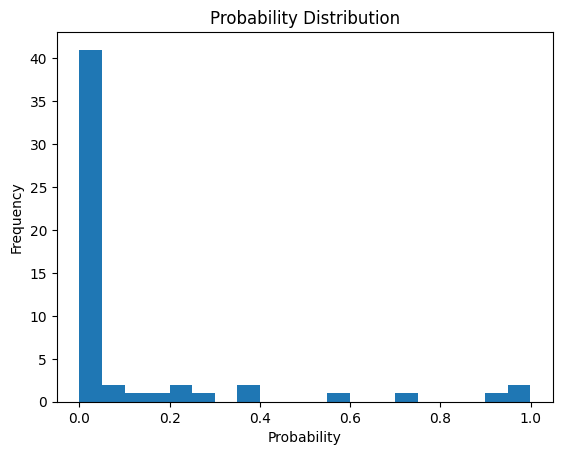

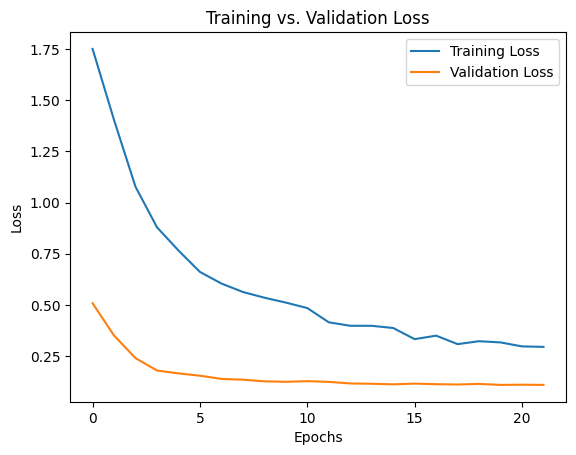

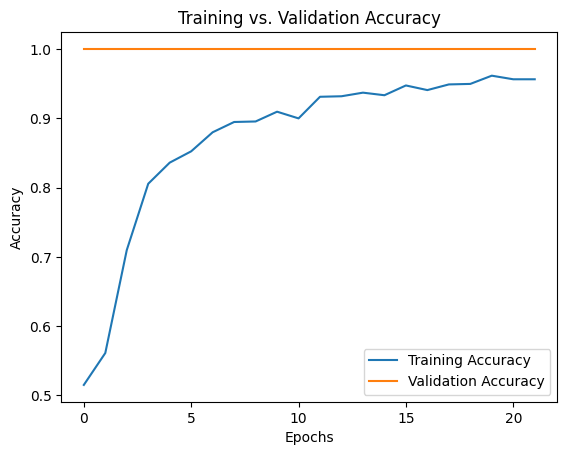

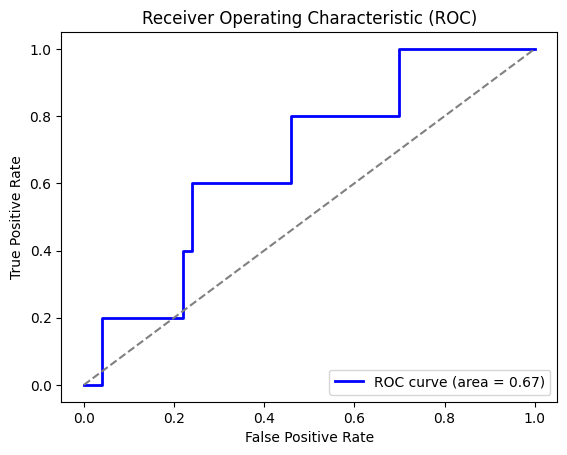

In [291]:
plt.hist(probabilities, bins=20)
plt.title("Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.show()

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()


/home/codespace/.python/current/lib/python3.12/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_478
Received: inputs=['Tensor(shape=(100, 50))']
  warnings.warn(msg)
/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_478
Received: inputs=['Tensor(shape=(200, 50))']
  warnings.warn(m

SHAP values shape: (50, 1)
X_test_pca shape: (55, 50)
Expanded SHAP values shape: (55, 50)


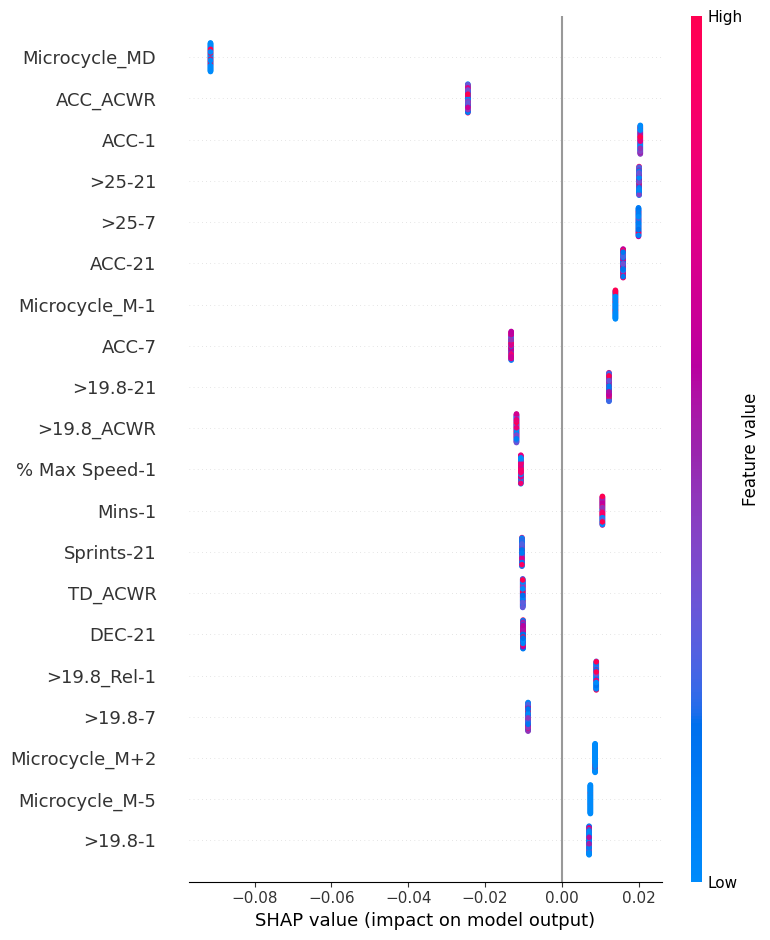

In [292]:
# Initialize SHAP explainer
explainer = shap.DeepExplainer(model, X_train_pca[:100])

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_pca)
shap_values = shap_values[0]  # Extract contributions for the positive class

# Debugging shapes
print("SHAP values shape:", shap_values.shape)
print("X_test_pca shape:", X_test_pca.shape)

num_metrics = len(metrics_train)-1

# Adjust SHAP values if necessary
if shap_values.shape == (num_metrics, 1):
    shap_values = shap_values.T  # Adjust to (1, num_metrics)
if shap_values.shape == (1, num_metrics):
    shap_values = np.tile(shap_values, (X_test_pca.shape[0], 1))  # Expand to (77, 41)
    print("Expanded SHAP values shape:", shap_values.shape)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test_pca, feature_names=X_train_selected.columns)

In [293]:
# Step 1: Compute mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Step 2: Create a DataFrame to store feature importance
shap_importance = pd.DataFrame({
    'Feature': X_train_selected.columns,
    'Mean SHAP Value': mean_shap_values
}).sort_values(by='Mean SHAP Value', ascending=False)

print("Feature importance:")
print(shap_importance)

Feature importance:
           Feature  Mean SHAP Value
49   Microcycle_MD         0.091454
37        ACC_ACWR         0.024476
3            ACC-1         0.020409
27          >25-21         0.020095
21           >25-7         0.019938
28          ACC-21         0.015935
44  Microcycle_M-1         0.013932
22           ACC-7         0.013187
26        >19.8-21         0.012256
33      >19.8_ACWR         0.011822
12   % Max Speed-1         0.010690
6           Mins-1         0.010544
30      Sprints-21         0.010397
31         TD_ACWR         0.010201
29          DEC-21         0.010112
8      >19.8_Rel-1         0.008951
20         >19.8-7         0.008802
42  Microcycle_M+2         0.008645
48  Microcycle_M-5         0.007411
1          >19.8-1         0.007076
5        Sprints-1         0.006851
10       ACC_Rel-1         0.006750
0             TD-1         0.006494
47  Microcycle_M-4         0.006282
32         TD_MSWR         0.005741
9        >25_Rel-1         0.005701
2       

In [294]:
# Step 3: Select the top X features
X = 15  # Number of top features to select
top_features = shap_importance['Feature'].head(X).tolist()

print(f"Top {X} features:", top_features)

Top 15 features: ['Microcycle_MD', 'ACC_ACWR', 'ACC-1', '>25-21', '>25-7', 'ACC-21', 'Microcycle_M-1', 'ACC-7', '>19.8-21', '>19.8_ACWR', '% Max Speed-1', 'Mins-1', 'Sprints-21', 'TD_ACWR', 'DEC-21']


In [295]:
# Step 4: Subset the data using the top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Step 5: Scale the selected features
scaler = StandardScaler()
X_train_top_scaled = scaler.fit_transform(X_train_top)
X_test_top_scaled = scaler.transform(X_test_top)

input_dim = X_train_top.shape[1]  # New input dimension based on top features

model = create_ann(input_dim)

# Step 7: Retrain the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Compute class weights to handle imbalance (optional)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

history = model.fit(
    X_train_top_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights # Optional
)

# Step 8: Evaluate the model
loss, accuracy = model.evaluate(X_test_top_scaled, y_test, verbose=0)
print(f"Loss: {loss}, Accuracy: {accuracy}")

Epoch 1/100


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4687 - loss: 0.8154 - val_accuracy: 0.0000e+00 - val_loss: 1.0471 - learning_rate: 0.0010
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6008 - loss: 0.7045 - val_accuracy: 0.0000e+00 - val_loss: 1.0153 - learning_rate: 0.0010
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6427 - loss: 0.6403 - val_accuracy: 0.1484 - val_loss: 0.9654 - learning_rate: 0.0010
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6908 - loss: 0.6135 - val_accuracy: 0.3472 - val_loss: 0.9013 - learning_rate: 0.0010
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7388 - loss: 0.5738 - val_accuracy: 0.5668 - val_loss: 0.7852 - learning_rate: 0.0010
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7427 - loss: 0.5359 - val_accuracy: 0.6083 - val_loss: 0.6763 - learning_rate: 0.0010
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7919 - loss: 0.4927 - val_accurac

In [297]:
probabilities = model.predict(X_test_top_scaled)

# Get predictions (rounded to 0 or 1)
y_pred = (probabilities > 0.35).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Confusion Matrix:
[[42  8]
 [ 4  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88        50
           1       0.11      0.20      0.14         5

    accuracy                           0.78        55
   macro avg       0.51      0.52      0.51        55
weighted avg       0.84      0.78      0.81        55



## SVM

SVM & GridSearch

In [35]:
# Standardize the features
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train_val_scaled, y_train)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['rbf', 'poly'],
    'class_weight': ['balanced', {0: 1, 1: 10}]
}

# Initialize the SVM model
svm_model = SVC(probability=True, random_state=42)

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=3)
grid_search.fit(X_resampled, y_resampled)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

# Use the best estimator for testing
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("Test Set AUC:", roc_auc)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.880 total time=   0.1s
[CV 2/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.859 total time=   0.1s
[CV 3/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.801 total time=   0.1s
[CV 4/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.918 total time=   0.1s
[CV 5/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.881 total time=   0.1s
[CV 1/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=poly;, score=0.566 total time=   0.0s
[CV 2/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=poly;, score=0.674 total time=   0.0s
[CV 3/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=poly;, score=0.581 total time=   0.0s
[CV 4/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=poly;, score=0.728 total time=   0.0s
[CV 5/5] END C=0.01, class_weight=

SVM with manually selecting the parameters

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.70      0.80        70
           1       0.12      0.43      0.19         7

    accuracy                           0.68        77
   macro avg       0.52      0.56      0.50        77
weighted avg       0.85      0.68      0.74        77

Test Set AUC: 0.5571428571428572


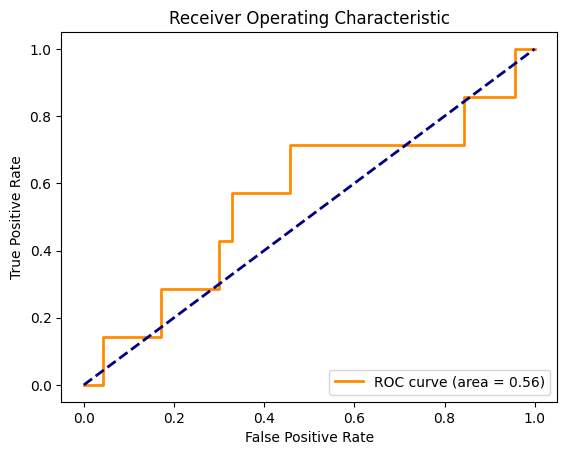

In [36]:
# Standardize the features
scaler = MinMaxScaler()
X_train_val_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train_val_scaled, y_train)

# # SMOTE for oversampling the training data
# smote_enn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X_train_val_scaled, y_train_val)

# Train the SVM model
svm_model = SVC(kernel='rbf', class_weight="balanced", gamma='auto',probability=True, random_state=42)
svm_model.fit(X_resampled, y_resampled)

# Evaluate on the test set
y_pred = svm_model.predict(X_test_scaled)
y_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("Test Set AUC:", roc_auc)

# Plot ROC Curve (optional)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## XGBoost Model

### Perform Recursive Feature Elimination with Cross-Validation (RFECV) to find the best variables

In [63]:
# Base parameters for XGBClassifier
base_params = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.8,  # Feature subsampling
    'subsample': 0.8,         # Row subsampling
    'eval_metric': 'auc',
    'alpha': 0,              # L1 regularization
    'gamma': 0,              # Minimum loss reduction
    'max_depth': 5,
    'learning_rate': 0.07,
    'n_estimators': 500
}

# Initialize the XGBClassifier
rfe_model = XGBClassifier(**base_params)

# Perform RFE for feature selection
rfe = RFE(
    estimator=rfe_model,
    n_features_to_select=50,  # Select exactly X features
    step=1  # Remove one feature at a time
)

# Fit RFE to X_train
rfe.fit(X_train, y_train)

# Get selected feature names
selected_features = X_train.columns[rfe.support_]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Selected Features (RFE): {selected_features.tolist()}")
print(f"Number of features selected: {len(selected_features)}")

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=50 > n_features=41. There will be no feature selection and all features will be kept.
  warnings.warn(


Selected Features (RFE): ['TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1', 'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1', 'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21', 'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR', '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR', 'DEC_ACWR', 'DEC_MSWR']
Number of features selected: 41


### Grid Search XGBoost

In [183]:
# Updated base parameters with added regularization
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,        
    'colsample_bytree': 0.8 
}

# Expanded parameter grid
param_grid = {
    'learning_rate': [0.01,0.05,0.07],
    'max_depth': [5, 7, 9, 11],
    'n_estimators': [300,500,700],
    'scale_pos_weight': [10,12,15,17],
    'alpha': [0],
    'gamma': [0],
}

scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train)
X_test_selected = scaler.transform(X_test)

model = XGBClassifier(**base_params_xgboost)

# Stratified K-Fold Cross-Validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',  # Optimize for ROC-AUC
    cv=stratified_cv,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the training dataset
grid_search.fit(X_train_selected, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_roc_auc = grid_search.best_score_

# Print best results
print(f"Best ROC-AUC (Grid Search): {best_roc_auc:.4f}")
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/home/codespace/.local/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best ROC-AUC (Grid Search): 1.0000
Best Parameters: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': 15}


### Train the model with the best parameters

Final Test ROC-AUC: 0.6440
Accuracy: 0.8909
Precision: 0.4286
Recall: 0.6000
F1 Score: 0.5000
Confusion Matrix:
[[46  4]
 [ 2  3]]


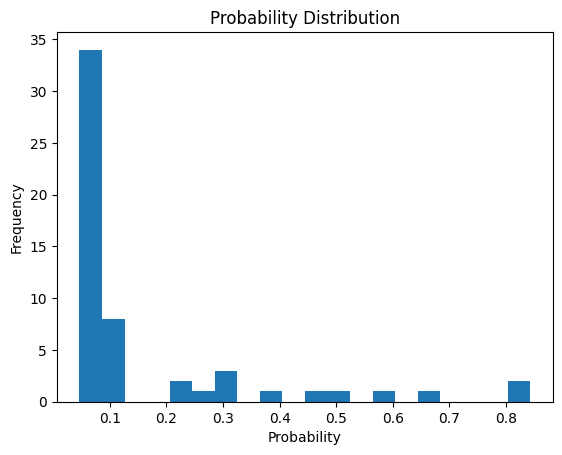

In [302]:
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,        
    'colsample_bytree': 0.9 
}

param_grid = {
   'learning_rate': 0.01,  # Explore smaller learning rates
   'max_depth': 13,            # Test broader depth values
   'n_estimators': 300,     # Include larger estimators
   'scale_pos_weight': 9,
   'alpha': 0,  # L regularization
   'gamma': 0,  # Minimum loss reduction
}

# Train the model with the best parameters from the grid search
# final_model = XGBClassifier(
#     **base_params_xgboost,
#     **param_grid,
# )


scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train
X_test_scaled = X_test

# pca = PCA(n_components=30)  # Retain 95% of variance
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# Train the model with manually selected parameters
final_model = XGBClassifier(
    **base_params_xgboost,
    **param_grid,
)

# Train
final_model.fit(X_train_scaled,
                y_train,
                verbose=True
)

# Predict class labels (0 or 1) on the test set
y_pred_probs = final_model.predict_proba(X_test_scaled)[:, 1]
# Apply custom threshold
threshold = 0.35
y_pred = (y_pred_probs >= threshold).astype(int)
test_roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"Final Test ROC-AUC: {test_roc_auc:.4f}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

plt.hist(y_pred_probs, bins=20)
plt.title("Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

In [303]:
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(final_model)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test)

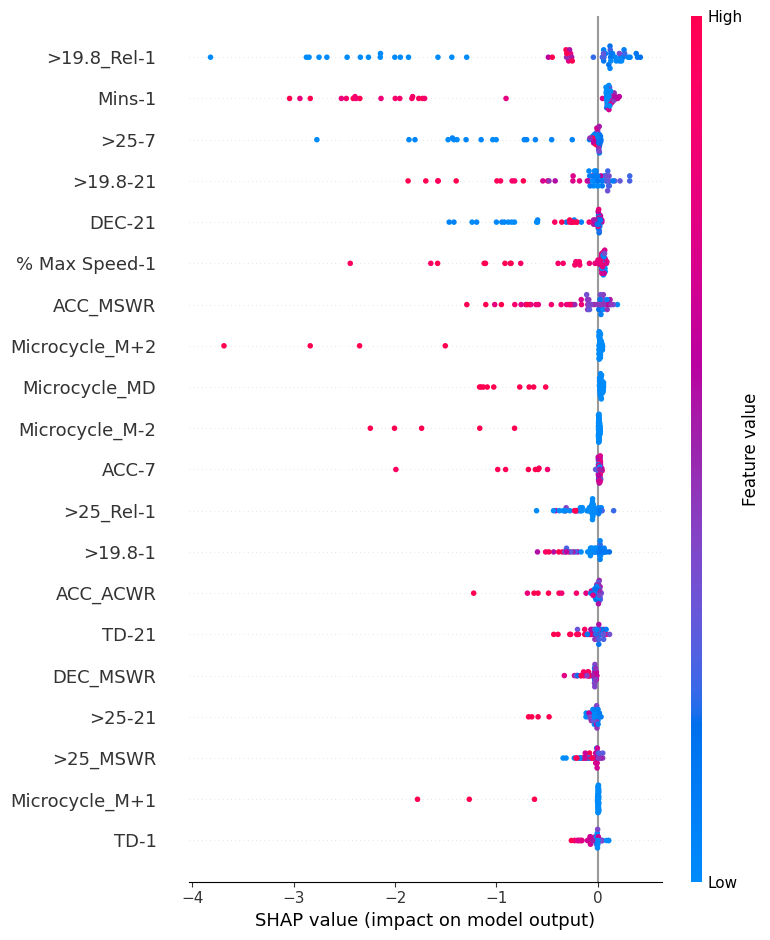

In [304]:
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns)

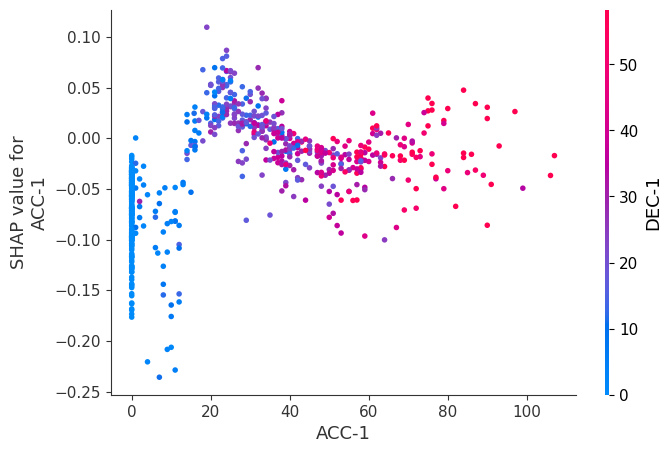

In [76]:
shap.dependence_plot("ACC-1", shap_values, X_test, interaction_index="DEC-1")

In [77]:
# Compute mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame to rank features by importance
shap_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean SHAP Value': mean_shap_values
}).sort_values(by='Mean SHAP Value', ascending=False)

# Select top features
top_features = shap_importance['Feature'].head(15).tolist()  # Select top 10 features

# Filter data to include only top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

scaler = StandardScaler()
X_train_top_scaled = scaler.fit_transform(X_train)
X_test_top_scaled = scaler.transform(X_test)

# Retrain the model
model_top = final_model
model_top.fit(X_train_top_scaled, y_train)

# Evaluate the new model
y_pred_top = model_top.predict(X_test_top_scaled)
accuracy_top = accuracy_score(y_test, y_pred_top)
print(f"Retrained Model Accuracy: {accuracy_top}")

# Predict class labels (0 or 1) on the test set
y_pred_probs = final_model.predict_proba(X_test)[:, 1]
# Apply custom threshold
threshold = 0.4
y_pred = (y_pred_probs >= threshold).astype(int)
test_roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"Final Test ROC-AUC: {test_roc_auc:.4f}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Retrained Model Accuracy: 0.9655172413793104
Final Test ROC-AUC: 0.3275
Accuracy: 0.9856
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[686   0]
 [ 10   0]]


/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Prepare the data to export in excel

In [40]:
X_test = X_test_selected.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
extra_cols_test = extra_cols_test.reset_index(drop=True)

AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'

Categorize the percentages into levels of risk

In [58]:
def categorize_risk(percentage):
    if percentage < 40:
        return 'Low Risk'
    elif 40 <= percentage < 70:
        return 'Medium Risk'
    else:
        return 'High Risk'

Create a df to later convert to excel and export

In [56]:
# Evaluate the best model on the test set
y_probs = final_model.predict_proba(X_test_selected)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_probs)

print(f"Test ROC-AUC: {test_roc_auc:.4f}")

# Convert the probabilities of injury risk (Class 1) to percentages
injury_risk_percentage = y_probs * 100

# Categorize the injury risk percentages
risk_levels = [categorize_risk(percentage) for percentage in injury_risk_percentage]

# Create the `results` DataFrame with only relevant metrics and calculated values
results = pd.DataFrame({
    'Player_ID': extra_cols_test['PlayerID'],
    'Date': extra_cols_test['DATE'], # Add player IDs
    'Actual_Label': y_test,  # Add actual labels
    '%': injury_risk_percentage,
    'Risk_Level': risk_levels
}).join(X_test[['TD-7', '>25-7', 'ACC-7', 'DEC-7', 'Sprints-7']])  # Add only relevant metrics

Test ROC-AUC: 0.7844


In [207]:
# Define risk level colors
color_mapping = {
    'High Risk': 'FF9999',  # Light Red
    'Medium Risk': 'FFFF99',  # Light Yellow
    'Low Risk': '99FF99'  # Light Green
}

# file_path_export = '/content/drive/MyDrive/WATFORD FC/Datos GPS/results.xlsx'
file_path_export = 'results.xlsx'

wb = Workbook()

# Write `results` to the first sheet
ws = wb.active
ws.title = "Injury Risk Results"
for r_idx, row in enumerate(dataframe_to_rows(results, index=True, header=True), start=1):
    for c_idx, value in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=value)

# Conditional formatting for `results`
risk_level_col_idx = list(results.columns).index("Risk_Level") + 2
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=risk_level_col_idx, max_col=risk_level_col_idx):
    for cell in row:
        risk_level = cell.value
        if risk_level in color_mapping:
            cell.fill = PatternFill(start_color=color_mapping[risk_level], end_color=color_mapping[risk_level], fill_type="solid")

# Save the workbook
wb.save(file_path_export)

## Mutual Info Regression formula (excluded for now)

In [ ]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

def mrmr_manual_regression(X, y, num_features):
    selected_features = []
    remaining_features = list(range(X.shape[1]))
    
    # Calculate mutual information for relevance (regression)
    relevance = mutual_info_regression(X, y)
    
    for _ in range(num_features):
        scores = []
        for feature in remaining_features:
            # Calculate redundancy with already selected features
            redundancy = np.mean([mutual_info_regression(X[:, feature].reshape(-1, 1), X[:, sel]) 
                                  for sel in selected_features]) if selected_features else 0
            
            # mRMR score = relevance - redundancy
            score = relevance[feature] - redundancy
            scores.append((feature, score))
        
        # Select the feature with the maximum score
        best_feature = max(scores, key=lambda x: x[1])[0]
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
    
    return selected_features

selected_features_indexes = mrmr_manual_regression(X.values, y.values, 8)

feature_names = X.columns  # Assuming X is a pandas DataFrame
selected_feature_names = [feature_names[i] for i in selected_features_indexes]

print("Selected Features:", selected_feature_names)

X = X[selected_feature_names]